In [1]:
# @title Завантаження пакетів { vertical-output: true }
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
from ipywidgets import interact
from matplotlib import pyplot as plt
from io import StringIO

In [2]:
# @title Викликаємо пакет методу найменших повних квадратів (ODR)
from scipy.odr import ODR, Model, RealData

# Перевірка Закону Кулона

## Мета роботи

Перевірити закон Кулона:
1. Визначити залежність сили від заряду;
2. визначити залежність сили від відстані;
3. визначити електричну сталу в системі SI.

## 1. Експериментальні результати та їх обробка

In [3]:
table = """
5.10e-9 0.03e-3 4.40e-9 0.04e-3 4.50e-9 0.02e-3 4.50e-9 0.02e-3 NaN     NaN
10.2e-9 0.18e-3 9.20e-9 0.09e-3 8.20e-9 0.08e-3 8.30e-9 0.08e-3 NaN     NaN
15.5e-9 0.39e-3 13.8e-9 0.19e-3 13.2e-9 0.12e-3 12.4e-9 0.11e-3 12.4e-9 0.071e-3
20.1e-9 0.65e-3 18.0e-9 0.32e-3 17.1e-9 0.19e-3 16.8e-9 0.16e-3 16.0e-9 0.11e-3
23.8e-9 0.94e-3 21.8e-9 0.46e-3 23.0e-9 0.36e-3 21.0e-9 0.24e-3 20.9e-9 0.16e-3
"""

In [4]:
l = ['l1 = 4 см', 'l2 = 5 см', 'l3 = 6 см', 'l4 = 7 см', 'l5 = 8 см']
d = ['q, Кл','F, Н']
midx = pd.MultiIndex.from_product([l, d])
df = np.loadtxt(StringIO(table))
df = pd.DataFrame(df, columns=midx)
df

l1 = 4 см              l2 = 5 см              l3 = 6 см           \
          q, Кл     F, Н         q, Кл     F, Н         q, Кл     F, Н   
0  5.100000e-09  0.00003  4.400000e-09  0.00004  4.500000e-09  0.00002   
1  1.020000e-08  0.00018  9.200000e-09  0.00009  8.200000e-09  0.00008   
2  1.550000e-08  0.00039  1.380000e-08  0.00019  1.320000e-08  0.00012   
3  2.010000e-08  0.00065  1.800000e-08  0.00032  1.710000e-08  0.00019   
4  2.380000e-08  0.00094  2.180000e-08  0.00046  2.300000e-08  0.00036   

      l4 = 7 см              l5 = 8 см            
          q, Кл     F, Н         q, Кл      F, Н  
0  4.500000e-09  0.00002           NaN       NaN  
1  8.300000e-09  0.00008           NaN       NaN  
2  1.240000e-08  0.00011  1.240000e-08  0.000071  
3  1.680000e-08  0.00016  1.600000e-08  0.000110  
4  2.100000e-08  0.00024  2.090000e-08  0.000160

Побудуємо графік для $l_1 = 4$ см. Заряд $[q] = \text{Кл}$, сила в $[F] = \text{мН}$

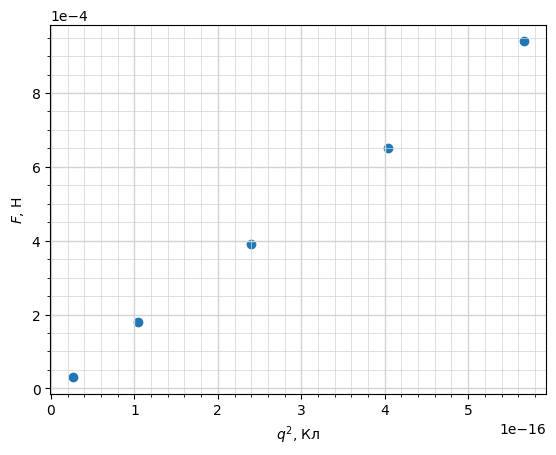

In [5]:
q = df[l[0]].iloc[:, 0] # Колонка з величинами заряду
F = df[l[0]].iloc[:, 1] # Колонка з величинами сили
plt.scatter(q**2, F)
plt.xlabel(r'$q^2$, Кл')
plt.ylabel(r'$F$, Н')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=1.0, color='lightgray')  # Мажорна сітка
plt.grid(which='minor', linestyle='-', linewidth=0.5, color='lightgray')  # Мінорна сітка
plt.show()


Задамо модель апроксимації $F(q^2) = \beta_0 \cdot q^2$

In [6]:
# Задаємо модельну функцію
def model_func(beta, qsqr):
    F =  beta[0] * qsqr
    return F

Здійснюємо підгону даних за моделлю

In [7]:
# https://docs.scipy.org/doc/scipy/reference/odr.html

# Створюємо екземпляр моделі
model = Model(model_func)

outputs = []
for i in range(len(l)):
    q = df[l[i]].iloc[:, 0] # Колонка з величинами заряду
    q = q[~np.isnan(q)] # Прибираємо NaN
    F = df[l[i]].iloc[:, 1] # Колонка з величинами сили
    F = F[~np.isnan(F)] # Прибираємо NaN
    data = RealData(q**2, F)

    # Створюємо ODR зі своїми даними, моделлю та початковою оцінкою параметрів
    odr = ODR(data, model, [1e12, 0])

    # Вибір методу підгонки
    odr.set_job(fit_type=0)
    output = odr.run()
    outputs.append(output)

Побудова даних

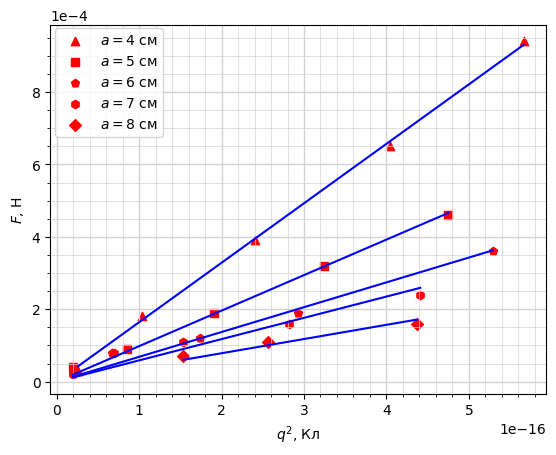

In [8]:
ks = []
Dks = []
markers=['^', 's', 'p', 'h', 'D']
for i in range(len(l)):
    q = df[l[i]].iloc[:, 0] # Колонка з величинами заряду
    F = df[l[i]].iloc[:, 1] # Колонка з величинами сили
    output = outputs[i]
    C = output.beta[0]
    ks.append(C)
    DC = output.sd_beta[0]
    Dks.append(DC)
    plt.plot(q**2, model_func(output.beta, q**2), color="b")
    plt.scatter(q**2, F, color='r', marker=markers[i], label=rf'$a = {i + 4}$ см')

plt.xlabel(r'$q^2$, Кл')
plt.ylabel(r'$F$, Н')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

plt.legend(bbox_to_anchor=(0.01, 0.99), loc='upper left', borderaxespad=0.)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=1.0, color='lightgray')  # Мажорна сітка
plt.grid(which='minor', linestyle='-', linewidth=0.5, color='lightgray')  # Мінорна сітка
plt.show()


З результатів апроксимації за формулою отримуємо наступні дані

In [19]:
table2 = pd.DataFrame({'inv_l2': 1/(np.array([4.,5.,6.,7.,8.])*1e-2)**2, 'C': ks, 'DC': Dks})
table2

,inv_l2,C,DC
0,625.000000,1.642142e+12,1.566689e+10
1,400.000000,9.807396e+11,1.904800e+10
2,277.777778,6.853914e+11,2.861462e+10
3,204.081633,5.873615e+11,4.513726e+10
4,156.250000,3.922396e+11,2.454115e+10


Задамо модель апроксимації  $\frac{F}{q^2} = \frac{k}4 \cdot\left(\frac1{l^2}\right) \rightarrow y = \frac{\beta_0}4 \cdot x$

In [11]:
def model_func(beta, inv_l2):
    C = beta[0]/4 * inv_l2
    return C

Створюємо ODR зі своїми даними, моделлю та початковою оцінкою параметрів

In [12]:
model = Model(model_func)

X = table2['inv_l2']
C = table2['C']
data = RealData(X, C)
odr = ODR(data, model, [0])

# Вибір методу підгонки
odr.set_job(fit_type=0)
output = odr.run()

Знаходимо значення коефіцієнта $k$ та $\Delta k$

In [22]:
k = output.beta[0]
Dk = output.sd_beta[0]

print(f'k = {k:.2e}')
print(f'Dk = {Dk:.0e}')

k = 1.03e+10
Dk = 2e+08


Будуємо графіки апроксимації

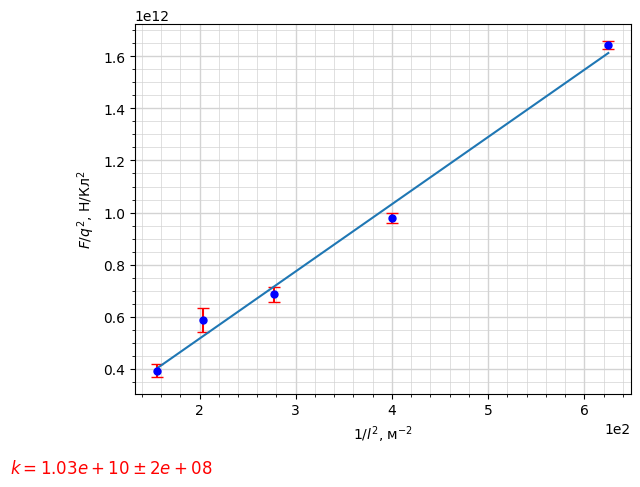

In [16]:
plt.errorbar(table2['inv_l2'], table2['C'], table2['DC'],
             fmt='o', ecolor='r', color='b',
             markersize=5, capsize=4)
plt.plot(table2['inv_l2'], model_func(output.beta, table2['inv_l2']))
plt.text(3, 20, fr'$k = {k:.2e} \pm {Dk:.0e}$', fontsize=12, color='red')

plt.xlabel(r'$1/l^2$, м$^{-2}$')
plt.ylabel(r'$F/q^2$, Н/Кл$^2$')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

# plt.legend(bbox_to_anchor=(0.01, 0.99), loc='upper left', borderaxespad=0.)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=1.0, color='lightgray')  # Мажорна сітка
plt.grid(which='minor', linestyle='-', linewidth=0.5, color='lightgray')  # Мінорна сітка
plt.show()

## Висновки

Табличне прецизійне значення

In [26]:
k_tab = 8.98755179231e9

In [36]:
epsilon = np.abs(k - k_tab)/(k_tab)*100

In [40]:
print(f'Відмінність нашого значення від табличного становить {epsilon:.0f} %')

Відмінність нашого значення від табличного становить 15 %


Для перевірки закону Кулона в нашій роботі ми користувались прямим методом, який має низьку точність, оскільки ефекти електростатичної індукції призводять до того, що заряди наводяться практично на всіх тілах, що оточуючих використовуваний прилад, а також, ці ефекти призводять до того, що заряд на кулькі розподілений нерівномірно. На точність також впливає і явище стікання електричного заряду з кульки. Однак, основна похибка обумовлена тим, що коромисло не вдається встановити в початкове положення, тобто визначити, коли нитка не закручена, бо цьому перешкоджає рух повітря навколо кульки. Для більш точної перевірки закону «обернених квадратів» сьогодні користуються непрямими методами, які полягають у вимірювання електричних потенціалів на концентричних сферах.